In [1]:
import pandas as pd 
import numpy as np
import math

import matplotlib.pyplot as plt


from scipy.optimize import fsolve

# Question 1

Calculate the mean and covariance matrix for the returns to 5 decimal places

In [2]:
class Portfolio:
    def __init__(self, df):
        self.df = df
        self.total_mean_return = []
        self.stock_returns = []
        
        self.mean = np.empty(0)
        self.covariance = np.empty(0)
        
        self.asset_tickers = ["BHP", "CSL", "NAB", "TCL", "TLS"]
        
        # number of stocks n portfolio
        self.N = 5

    def returns(self):
        for column in self.df.columns:
            if column != "Date":
                stock_return = []
                i = 0
                s_prev = 0
                for s_cur in self.df[column]:
                    if i != 0:
                        stock_return.append((s_cur - s_prev) / s_prev)
                        s_prev = s_cur
                    else:
                        s_prev = s_cur
                    i += 1

                self.total_mean_return.append(np.mean(stock_return))
                self.stock_returns.append(stock_return)

        self.mean = np.round(np.array(self.total_mean_return).reshape(-1, 1), 5)
        self.covariance = np.round(np.cov(self.stock_returns), 5)
#         self.mean = np.array([[1], [2], [0]])
#         self.covariance = np.array([[1,0,0],[0,2,0],[0,0,1]])

df = pd.read_csv('project_data.csv')

portfolio = Portfolio(df)

portfolio.returns()
print("Mean Returns")
for i in range(len(portfolio.asset_tickers)):
    print(f"{portfolio.asset_tickers[i]}: t =  {portfolio.mean[i][0]}")


print(f"Covariance Matrix - C: {portfolio.covariance}")


Mean Returns
BHP: t =  0.00099
CSL: t =  0.00023
NAB: t =  0.00013
TCL: t =  0.00015
TLS: t =  0.00058
Covariance Matrix - C: [[ 3.0e-04 -1.0e-05  3.0e-05  2.0e-05 -1.0e-05]
 [-1.0e-05  1.2e-04  3.0e-05  4.0e-05  3.0e-05]
 [ 3.0e-05  3.0e-05  1.5e-04  4.0e-05  2.0e-05]
 [ 2.0e-05  4.0e-05  4.0e-05  1.0e-04  3.0e-05]
 [-1.0e-05  3.0e-05  2.0e-05  3.0e-05  7.0e-05]]


# Question 2

Find the optimal portfolio x(t) for investors with risk-aversion parameter t (i.e. your answer\
should be a function of t). For what value(s) of t ≥ 0 does the optimal portfolio have no short\
selling of any asset

Optimal porfolio
BHP: t =  (x - 0.13629) / 2.32155
CSL: t =  (x - 0.16811) / -1.17309
NAB: t =  (x - 0.11746) / -2.09877
TCL: t =  (x - 0.13642) / -3.70843
TLS: t =  (x - 0.44172) / 4.65875


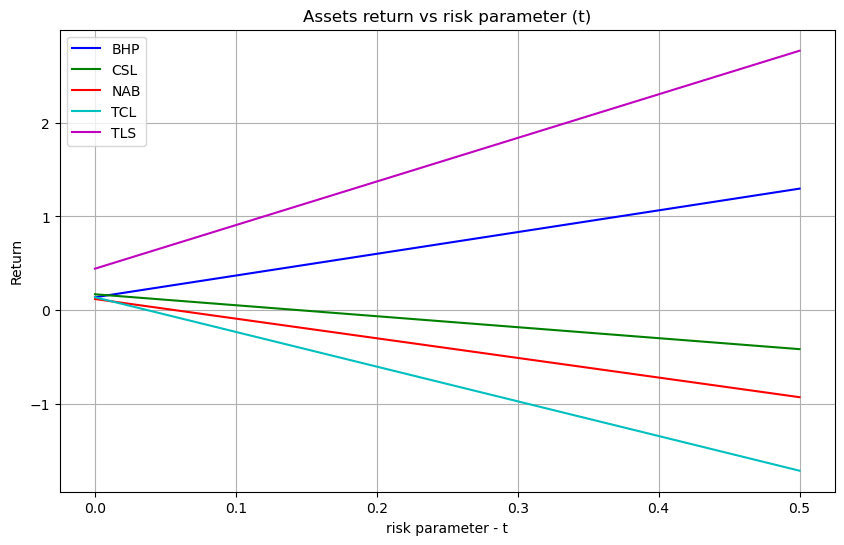

the values of t where there is no short selling is from 0 < t <= 0.03679


In [3]:
def optimal_portfolio():
    # PART A
    c_inv = np.linalg.inv(portfolio.covariance)
    e = np.ones((portfolio.N, 1))
    
    a = np.dot(np.dot(e.T, c_inv), e)
    b = np.dot(np.dot(portfolio.mean.T, c_inv), e)
    c = np.dot(np.dot(portfolio.mean.T, c_inv), portfolio.mean)
    d = (a * c) - (b * b)

    alpha = (1 / a) * np.dot(c_inv, e)
    beta = np.dot(c_inv, portfolio.mean - ((b / a) * e))

    t = []
  
    for i, j in zip(alpha, beta):
       
        t.append("(x - " + str(np.round(i[0], 5)) + ") / " + str(np.round(j[0],5)))

    print("Optimal porfolio")
    for i in range(len(portfolio.asset_tickers)):
        print(f"{portfolio.asset_tickers[i]}: t =  {t[i]}")
    
    # PART B
    
    BHP_return = lambda t: alpha[0][0] + t * beta[0][0]
    CSL_return = lambda t: alpha[1][0] + t * beta[1][0]
    NAB_return = lambda t: alpha[2][0] + t * beta[2][0]
    TCL_return = lambda t: alpha[3][0] + t * beta[3][0]
    TSL_return = lambda t: alpha[4][0] + t * beta[4][0]

    
    t_values = np.linspace(0, 0.5, 100) 

    returns_BHP = [BHP_return(t) for t in t_values]
    returns_CSL = [CSL_return(t) for t in t_values]
    returns_NAB = [NAB_return(t) for t in t_values]
    returns_TCL = [TCL_return(t) for t in t_values]
    returns_TLS = [TSL_return(t) for t in t_values]

    plt.figure(figsize=(10, 6))

    plt.plot(t_values, returns_BHP, label='BHP', color='b')
    plt.plot(t_values, returns_CSL, label='CSL', color='g')
    plt.plot(t_values, returns_NAB, label='NAB', color='r')
    plt.plot(t_values, returns_TCL, label='TCL', color='c')
    plt.plot(t_values, returns_TLS, label='TLS', color='m')

    plt.xlabel('risk parameter - t')
    plt.ylabel('Return')
    plt.title('Assets return vs risk parameter (t)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # as risk parameter t increases, TCL is the first asset to violate 
    # the x >= 0 constraint. Therefore t can only exist from 
    # 0 -> when TCL intersects 0 .
    
    initial_guess = 0.0
    t_upper_range = fsolve(TCL_return, initial_guess)
    
    print(f"the values of t where there is no short selling is "
          f"from 0 < t <= {np.round(t_upper_range[0], 5)}")

    
    
optimal_portfolio()

# Question 3

Consider a specific investor with risk aversion parameter t = 0.04 who wants to invest $10,000\
in these assets.
(a) What is their optimal investment allocation, mean return and risk (standard deviation)\
of their investment? Give all answers in dollars.\
(b) Suppose now the investor does not want to short sell any asset. What is their new optimal\
portfolio, mean return and risk (standard deviation)? Again, give all answers in dollars

In [4]:
def specific_optimal_portfolio(t, money, can_short_sell):
    c_inv = np.linalg.inv(portfolio.covariance)
    e = np.ones((portfolio.N, 1))
    
    a = np.dot(np.dot(e.T, c_inv), e)
    b = np.dot(np.dot(portfolio.mean.T, c_inv), e)
    c = np.dot(np.dot(portfolio.mean.T, c_inv), portfolio.mean)
    d = (a * c) - (b * b)

    alpha = (1 / a) * np.dot(c_inv, e)
    beta = np.dot(c_inv, portfolio.mean - ((b / a) * e))

    x = alpha + (t * (beta))
    
    if can_short_sell:
        allocation = money * x
        
        mean = ((b + (d * t)) / a) * money
        
        variance = (1 + (d * (t**2))) / a
        sd = math.sqrt(variance) * money
        
        for i in range(len(portfolio.asset_tickers)):
            print(f"Allocation of money "
                  f"{portfolio.asset_tickers[i]}: {allocation[i][0]:.5f}")
      
        print(f"mean return: {mean[0][0]:.5f}")      
        
        print(f"risk: {sd:.5f}")
        
        return a, b, c, d
        
    else:
        new_mean_returns = []
        new_covariance_returns = []
        dropped_index = []
        
        for i in range(len(x)):
            if x[i] < 0:
                dropped_index.append(i)

        if len(dropped_index) == 0:
            new_mean_returns = portfolio.mean
            new_covariance_returns = portfolio.covariance
        else:           
            offset = 0
            for index in dropped_index:
                if index != 0:
                    index -= offset
                new_mean_returns = np.array(np.delete(portfolio.mean, index))
                
                new_covariance_returns = np.delete(
                    portfolio.covariance, index, axis = 0
                )
                new_covariance_returns = np.delete(
                    new_covariance_returns, index, axis = 1
                )
                offset += 1
                
    
            new_mean_returns = new_mean_returns.reshape(-1, 1)              
                
            c_inv_hat = np.linalg.inv(new_covariance_returns)
            e_hat = np.ones((len(new_mean_returns), 1))
        
            a_hat = np.dot(np.dot(e_hat.T, c_inv_hat), e_hat)
            b_hat = np.dot(np.dot(new_mean_returns.T, c_inv_hat), e_hat)
            c_hat = np.dot(np.dot(new_mean_returns.T, c_inv_hat), new_mean_returns)
            d_hat = (a_hat * c_hat) - (b_hat * b_hat)

            alpha_hat = (1 / a_hat) * np.dot(c_inv_hat, e_hat)
            beta_hat = np.dot(
                c_inv_hat, new_mean_returns - ((b_hat / a_hat) * e_hat)
            )

            x_hat = alpha_hat + (t * beta_hat)

            allocation = money * x_hat
            mean = ((b_hat + (d_hat * t)) / a_hat) * money
        
            variance = (1 + (d_hat * t**2)) / a_hat
            sd = math.sqrt(variance) * money
            
            for index in dropped_index:
                allocation = np.insert(allocation, index, [[0.0]], axis=0)
            
            for i in range(len(portfolio.asset_tickers)):
                print(f"Allocation of money "
                      f"{portfolio.asset_tickers[i]}: {allocation[i][0]:.5f}")

            print(f"mean return: {mean[0][0]:.5f}")

            print(f"risk: {sd:.5f}")
            
#             return a, b, c, d
    
t = 0.04
money = 10000

print("Short selling allowed")
optimal_a, optimal_b, optimal_c, optimal_d = specific_optimal_portfolio(
    t, money, True
)

print("\nNo short selling allowed")
specific_optimal_portfolio(t, money, False)

Short selling allowed
Allocation of money BHP: 2291.56092
Allocation of money CSL: 1211.85325
Allocation of money NAB: 335.09072
Allocation of money TCL: -119.15791
Allocation of money TLS: 6280.65302
mean return: 6.21584
risk: 68.76382

No short selling allowed
Allocation of money BHP: 2279.16318
Allocation of money CSL: 1179.24686
Allocation of money NAB: 310.62762
Allocation of money TCL: 0.00000
Allocation of money TLS: 6230.96234
mean return: 6.18194
risk: 68.57428


# Question 4

Illustrate this problem graphically: in the (σ, μ) plane, show (on the same graph):\
(i) The 5 assets: BHP, CSL, NAB, TCL, TLS\
(ii) The optimal (unconstrained) portfolio for the investor from Question 3(a)\
(iii) The minimum risk portfolio\
(iv) The efficient frontier and minimum variance frontier\
(v) 5000 randomly generated feasible portfolios

C:\Users\edenz\AppData\Local\Temp\ipykernel_22756\3485679906.py:30: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((x ** 2 - (1/optimal_a[0][0])) *
C:\Users\edenz\AppData\Local\Temp\ipykernel_22756\3485679906.py:36: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((x ** 2 - (1/optimal_a[0][0])) *


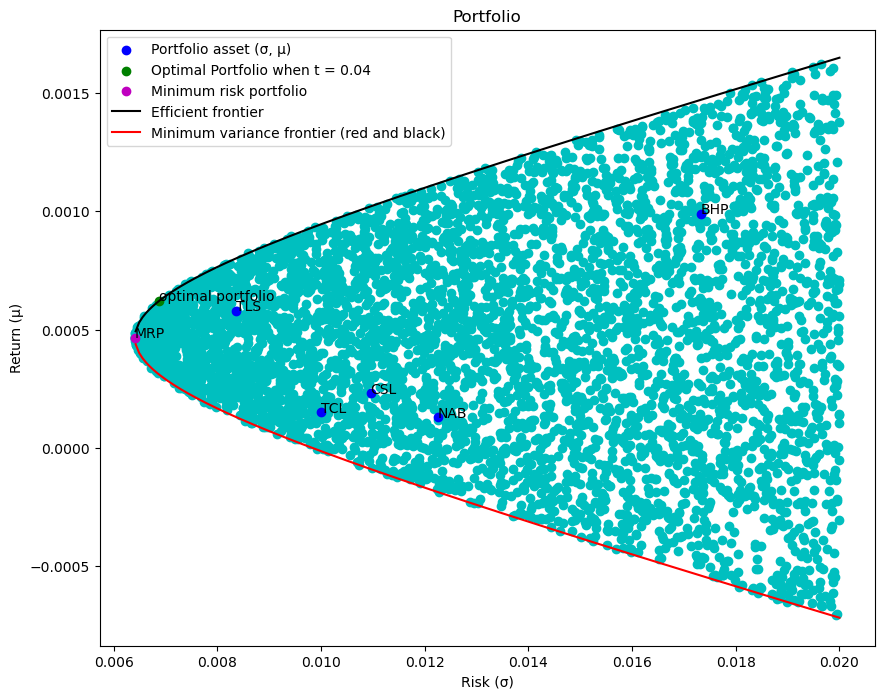

In [5]:
def illustration_graph():

    mu = []
    sig = []
    
    plt.figure(figsize=(10, 8))

    # part I
    for i in range(portfolio.N):
        mu.append(portfolio.mean[i][0])
        sig.append(math.sqrt(portfolio.covariance[i][i]))

    # plotting for part I is done below part V. 
    # this is done to prevent these values from being overlapped
    # this is repeated for parts 2 - 4

    # part II
    optimal_mean = (optimal_b[0][0] + (optimal_d[0][0] * t)) / optimal_a[0][0]
    optimal_variance = (1 + (optimal_d[0][0] * (t ** 2))) / optimal_a[0][0]
    
    # part III
    sig_mrp = 1 / np.sqrt(optimal_a[0][0])
    mu_mrp = optimal_b[0][0] / optimal_a[0][0]

    # PART IV
    x = np.linspace(0, 0.02, 300)

    y_pos = (
        optimal_b[0][0]/optimal_a[0][0] + 
        np.sqrt((x ** 2 - (1/optimal_a[0][0])) * 
        (optimal_d[0][0]/optimal_a[0][0]))
    )
    
    y_neg = (
        optimal_b[0][0]/optimal_a[0][0] - 
        np.sqrt((x ** 2 - (1/optimal_a[0][0])) * 
        (optimal_d[0][0]/optimal_a[0][0]))
    )

    # PART V 
    N_random = 5000
    random_sigs = np.random.uniform(sig_mrp, 0.02, N_random) 
    random_mus = []
    
    # to ensure reproducibility
    np.random.seed(1)
    
    for random_sig in random_sigs:
        
        mu_upper_bound = (
            optimal_b[0][0]/optimal_a[0][0] + 
            np.sqrt((random_sig ** 2 - (1/optimal_a[0][0])) *
            (optimal_d[0][0]/optimal_a[0][0]))
        )
        
        mu_lower_bound = (
            optimal_b[0][0]/optimal_a[0][0] - 
            np.sqrt((random_sig ** 2 - (1/optimal_a[0][0])) *
            (optimal_d[0][0]/optimal_a[0][0]))
        )
        
        random_mu = np.random.uniform(mu_lower_bound, mu_upper_bound)
        random_mus.append(random_mu)
        
    
    for i in range(N_random):
        plt.scatter(random_sigs[i], random_mus[i], color = 'c')
        
    # graphing for part I
    plt.scatter(
        sig, mu, 
        color = "blue", 
        marker = "o", 
        label = "Portfolio asset (σ, μ)"
    )

    for i, asset_ticker in enumerate(portfolio.asset_tickers):
        plt.annotate(asset_ticker, (sig[i], mu[i]))
        
    # graphing for part II
    plt.scatter(
        np.sqrt(optimal_variance), optimal_mean, 
        color="g", 
        marker="o", 
        label="Optimal Portfolio when t = 0.04"
    )
    plt.annotate("optimal portfolio", (np.sqrt(optimal_variance), optimal_mean))

    
    # graphing for part III
    plt.scatter(
        sig_mrp, mu_mrp, 
        label = 'Minimum risk portfolio', 
        marker = "o", 
        color = "m"
    )
    plt.annotate("MRP", (sig_mrp, mu_mrp))
    
    # graphing for part IV
    plt.plot(x, y_pos, label = 'Efficient frontier', color = 'black')
    
    plt.plot(
        x, y_neg, 
        label = 'Minimum variance frontier (red and black)', 
        color = 'r'
    )
    
    plt.xlabel('Risk (σ)')
    plt.ylabel('Return (μ)')
    plt.title('Portfolio')
    plt.legend()
    
    
illustration_graph()


# Question 5

Suppose now that the market also has a risk-free cash asset with return 0.0001.\
(a) What is the new optimal portfolio for the investor from Question 3 (with short selling
allowed)? Is this a borrowing or lending portfolio?\
(b) In a new plot, show in the (σ, μ) plane:\
(i) The 5 assets\
(ii) The optimal unconstrained portfolios for the investor with only risky assets (Ques-\
tion 3a) and with a risk-free asset (Question 5a)\
(iii) The efficient frontier and minimum variance frontier\
(iv) The capital market line\
(v) The market portfolio\
I recommend you use axis range σ ∈ [0, 0.02] for this plot, but you may choose other\
values if you prefer

New optimal portfolio
Risk free asset: 0.64376
BHP: 0.14142
CSL: 0.01296
NAB: -0.04211
TCL: -0.09974
TLS: 0.34371

Since mu_hat: 0.00039 is between the range of r_0: 0.0001 and mu_market_portfolio 0.0009, this is a lending portfolio


C:\Users\edenz\AppData\Local\Temp\ipykernel_22756\1778747745.py:77: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((x ** 2 - (1 / optimal_a[0][0])) *
C:\Users\edenz\AppData\Local\Temp\ipykernel_22756\1778747745.py:83: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((x ** 2 - (1 / optimal_a[0][0])) *


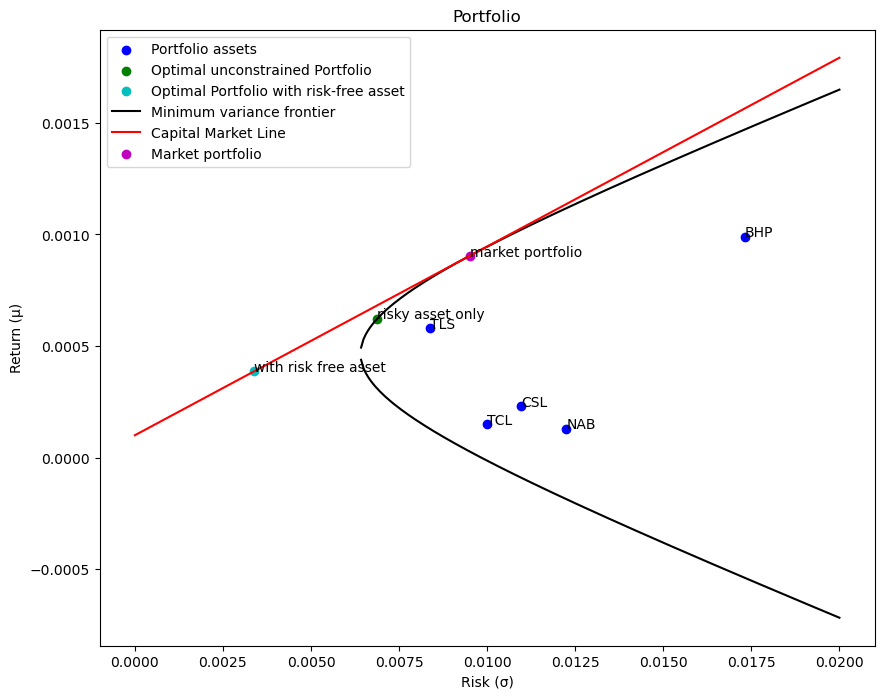

In [6]:
def optimal_portfolio_with_risk_free_asset(t, return_risk_free_asset):
    
    plt.figure(figsize=(10, 8))
    
    # PART A
    x_hat = []
    
    c_inv = np.linalg.inv(portfolio.covariance)
    e = np.ones((portfolio.N, 1))
    
    r_bar = portfolio.mean - (return_risk_free_asset * e)
    
    c_bar = np.dot(np.dot(r_bar.T, c_inv), r_bar)
    
    
    risky_asset = t * np.dot(c_inv, r_bar) 
    
    risk_free_asset = 1 - t * np.dot(e.T, np.dot(c_inv, r_bar))
    
    x_hat.append(risk_free_asset[0][0])
    
    for asset in risky_asset:
        x_hat.append(asset[0])
    
    print("New optimal portfolio")
    for i in range(len(portfolio.asset_tickers) + 1):
        if i != 0:
            print(f"{portfolio.asset_tickers[i-1]}: {x_hat[i]:.5f}")
        else:
            print(f"Risk free asset: {x_hat[i]:.5f}")

    # other part of PART A is at the bottom since we use 
    # market portfolio to define if it is borrowing 
    # or lending portfolio
    
    # PART B
    mu = []
    sig = []

    # part I
    for i in range(portfolio.N):
        mu.append(portfolio.mean[i][0])
        sig.append(math.sqrt(portfolio.covariance[i][i]))

    plt.scatter(sig, mu, color = "blue", marker = "o", label = "Portfolio assets")

    for i, asset_ticker in enumerate(portfolio.asset_tickers):
        plt.annotate(asset_ticker, (sig[i], mu[i]))

    # part II

    optimal_mean = (optimal_b[0][0] + (optimal_d[0][0] * t)) / optimal_a[0][0]
    optimal_variance = (1 + (optimal_d[0][0] * (t ** 2))) / optimal_a[0][0]
    
    plt.scatter(
        np.sqrt(optimal_variance), 
        optimal_mean, 
        color="g", 
        marker="o", 
        label="Optimal unconstrained Portfolio"
    )
    plt.annotate("risky asset only", (np.sqrt(optimal_variance), optimal_mean))
    
    mu_hat = return_risk_free_asset + t * c_bar
    
    variance_hat = c_bar * (t**2)
    sig_hat = np.sqrt(variance_hat)
    
    plt.scatter(sig_hat, mu_hat, color = 'c', label = "Optimal Portfolio with risk-free asset")
    plt.annotate("with risk free asset", (sig_hat, mu_hat))

    # PART III
    x = np.linspace(0, 0.02, 300)
    
    y_pos = (
        optimal_b[0][0] / optimal_a[0][0] + 
        np.sqrt((x ** 2 - (1 / optimal_a[0][0])) * 
        (optimal_d[0][0] / optimal_a[0][0]))
    )
    
    y_neg = (
        optimal_b[0][0] / optimal_a[0][0] - 
        np.sqrt((x ** 2 - (1 / optimal_a[0][0])) * 
        (optimal_d[0][0] / optimal_a[0][0]))
    )
    plt.plot(x, y_pos, color = 'black')
    plt.plot(x, y_neg, label = 'Minimum variance frontier', color = 'black')


    # PART IV
    
    cml = return_risk_free_asset + (np.sqrt(c_bar[0][0]) * x)
    
    plt.plot(x, cml, label = 'Capital Market Line', color = 'red')
    
    # PART V
    market_portfolio = lambda sig_hat: (return_risk_free_asset + \
                                        (np.sqrt(c_bar[0][0]) * sig_hat)) - \
                                        (optimal_b[0][0] / optimal_a[0][0] + \
                                         np.sqrt((sig_hat ** 2 - \
                                        (1 / optimal_a[0][0])) * \
                                        (optimal_d[0][0] / optimal_a[0][0])))
    
    initial_guess = 0.01
    sig_market_portfolio = fsolve(market_portfolio, initial_guess)
    
    mu_market_portfolio = (
        return_risk_free_asset + 
       (np.sqrt(c_bar[0][0]) * 
        sig_market_portfolio)
    )

    plt.scatter(
        sig_market_portfolio, mu_market_portfolio, 
        label = "Market portfolio", 
        color = 'm'
    )
    plt.annotate("market portfolio", (sig_market_portfolio, mu_market_portfolio))
    
    plt.xlabel('Risk (σ)')
    plt.ylabel('Return (μ)')
    plt.title('Portfolio')
    plt.legend()
    
    # part A
    
    print(f"\nSince mu_hat: {np.round(mu_hat[0][0], 5)} "
          f"is between the range of r_0: {return_risk_free_asset} "
          f"and mu_market_portfolio {np.round(mu_market_portfolio[0],5)}, " 
          f"this is a lending portfolio")
    
    
    return sig_market_portfolio, mu_market_portfolio

sig_market_portfolio, mu_market_portfolio = optimal_portfolio_with_risk_free_asset(
    0.04, 0.0001
)

# Question 6

Take the market portfolio from Question 5b(v) as the market portfolio for this question.\
(a) Compute the betas of the 5 stocks in the market.\
(b) With reference to the underlying businesses, explain why the betas of BHP and TCL are\
so different. Your answer should be brief, at most 1 paragraph.

In [7]:
# question 6
def stock_beta(return_risk_free_asset):
    # using CAPM model to estimate 
    # Rk = ak + βkRM
    # βk = (r - r0) / (rm - r0)
    beta = []
    
    for mean_return in portfolio.mean:
        beta.append(
            (mean_return[0] - return_risk_free_asset) / 
            (mu_market_portfolio[0] - return_risk_free_asset)
        )
       
    print("Betas")
    for i in range(len(portfolio.asset_tickers)):
        print(f"{portfolio.asset_tickers[i]}: {beta[i]:.5f}")

stock_beta(0.0001)

Betas
BHP: 1.10752
CSL: 0.16177
NAB: 0.03733
TCL: 0.06222
TLS: 0.59732
